C:\Users\Louis\anaconda3\envs\HTSAT_env\lib\site-packages\librosa\filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


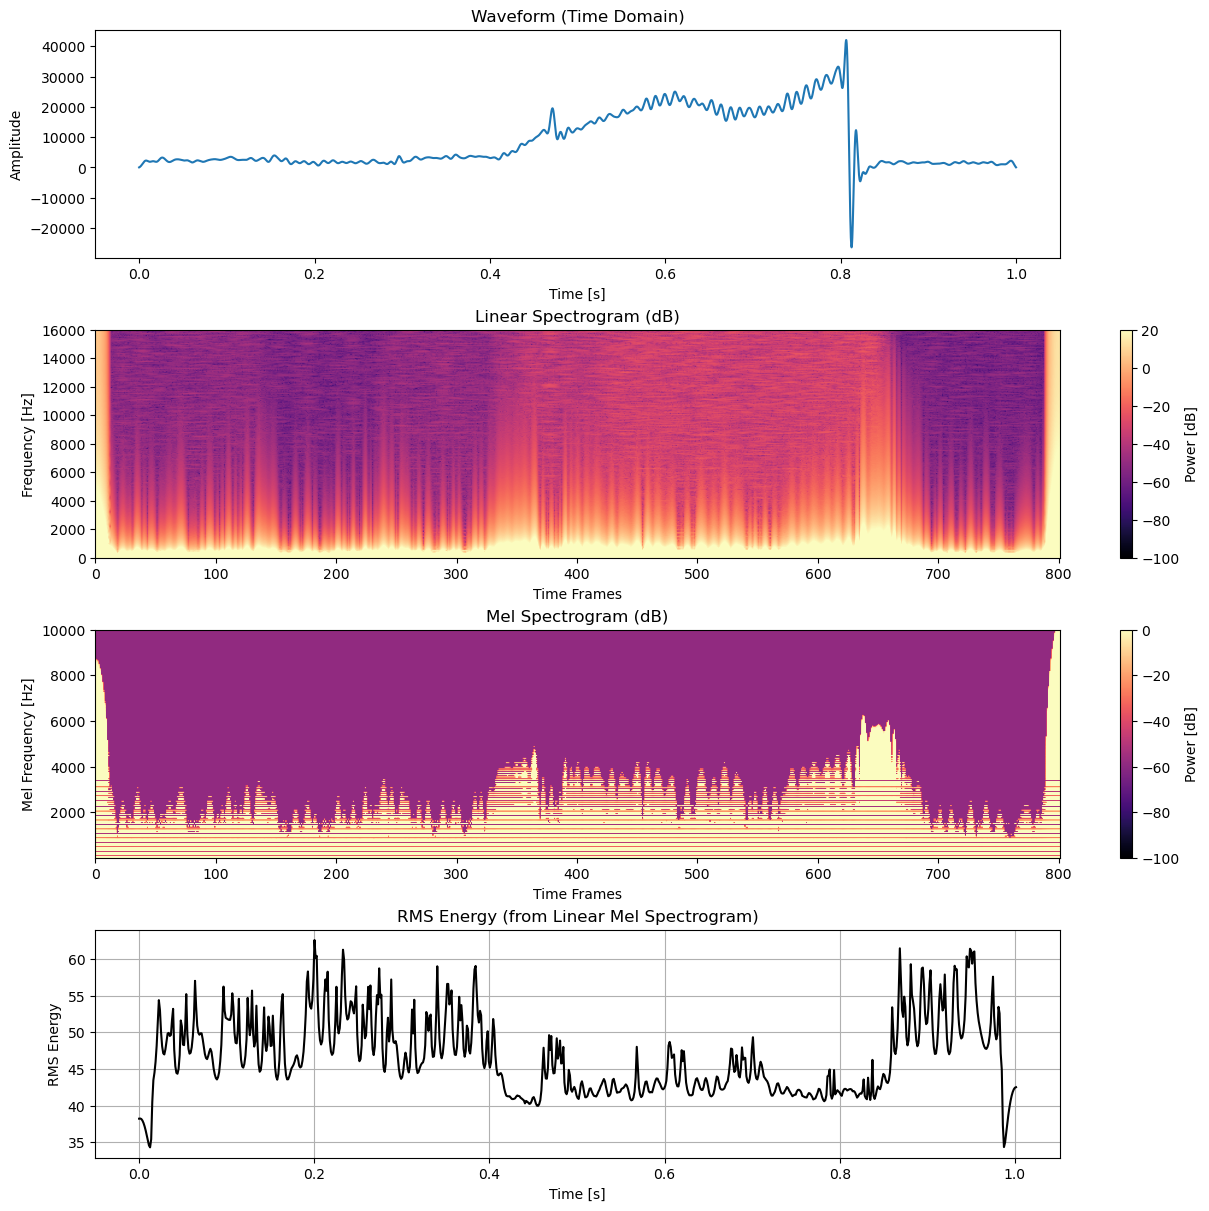

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchaudio
import librosa
from torchlibrosa.stft import Spectrogram, LogmelFilterBank

# === Load audio and preserve raw amplitude ===
file_path = r"C:\Users\Louis\PycharmProjects\HTS-Audio-Transformer\workspace\esc-50\raw\ESC-50-master\audio_gaussian\P5_6_2S1JoiningH4000_cycle_204.wav"
waveform, sr = torchaudio.load(file_path)
waveform = waveform * 32768  # Undo torchaudio float scaling (if originally int16)

# === Resample to 32 kHz if needed ===
target_sr = 32000
if sr != target_sr:
    waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=target_sr)(waveform)
    sr = target_sr

# Use mono if stereo
if waveform.shape[0] > 1:
    waveform = waveform[0].unsqueeze(0)

# === Parameters ===
n_fft = 1024
hop_size = 40
n_mels = 256
fmin = 10
fmax = 10000

# === Create spectrogram and mel filterbanks ===
spectrogram = Spectrogram(
    n_fft=n_fft,
    hop_length=hop_size,
    win_length=n_fft,
    window="hann",
    center=True,
    pad_mode="reflect",
    freeze_parameters=True
)

logmel = LogmelFilterBank(
    sr=sr,
    n_fft=n_fft,
    n_mels=n_mels,
    fmin=fmin,
    fmax=fmax,
    ref=1.0,
    amin=1e-10,
    top_db=None,
    freeze_parameters=True
)

# === Compute spectrograms ===
with torch.no_grad():
    spec = spectrogram(waveform)  # (1, 1, time, freq)
    spec_db = 10 * torch.log10(spec + 1e-10)[0, 0].T.numpy()

    mel_spec = logmel(spec)[0, 0].T.numpy()  # shape: (mel_bins, time)

    # === Compute RMS from linear mel spectrogram ===
    rms = np.sqrt(np.mean(mel_spec ** 2, axis=0))  # shape: (time,)
    rms_time = np.linspace(0, len(rms) * hop_size / sr, len(rms))

    # === Convert mel spec to dB scale (for plotting only) ===
    mel_spec_db = librosa.power_to_db(mel_spec, ref=1.0)

# === Time axis for waveform ===
waveform_np = waveform[0].numpy()
time_axis = np.linspace(0, len(waveform_np) / sr, len(waveform_np))

# === Frequency axis for linear spec ===
freqs = np.linspace(0, sr // 2, n_fft // 2 + 1)

# === Plot ===
fig, axs = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)

# 1. Time-Domain Waveform
axs[0].plot(time_axis, waveform_np)
axs[0].set_title("Waveform (Time Domain)")
axs[0].set_xlabel("Time [s]")
axs[0].set_ylabel("Amplitude")

# 2. Linear Spectrogram (in dB)
im1 = axs[1].imshow(spec_db, origin='lower', aspect='auto', cmap='magma',
                    extent=[0, spec_db.shape[1], freqs[0], freqs[-1]],
                    vmin=-100, vmax=20)
axs[1].set_title("Linear Spectrogram (dB)")
axs[1].set_xlabel("Time Frames")
axs[1].set_ylabel("Frequency [Hz]")
fig.colorbar(im1, ax=axs[1], label='Power [dB]')

# 3. Mel Spectrogram (dB)
im2 = axs[2].imshow(mel_spec_db, origin='lower', aspect='auto', cmap='magma',
                    extent=[0, mel_spec_db.shape[1], fmin, fmax],
                    vmin=-100, vmax=0)
axs[2].set_title("Mel Spectrogram (dB)")
axs[2].set_xlabel("Time Frames")
axs[2].set_ylabel("Mel Frequency [Hz]")
fig.colorbar(im2, ax=axs[2], label='Power [dB]')

# 4. RMS from Mel Spectrogram
axs[3].plot(rms_time, rms, color='black')
axs[3].set_title("RMS Energy (from Linear Mel Spectrogram)")
axs[3].set_xlabel("Time [s]")
axs[3].set_ylabel("RMS Energy")
axs[3].grid(True)

plt.show()
